# Model Spot Checking

In [11]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
#from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Modelos de clasificación
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
    ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

data_folder = "dataset_bc"

# Cargar conjuntos de datos
X_train = pd.read_csv(f"{data_folder}/X_train.csv")
y_train = pd.read_csv(f"{data_folder}/y_train.csv").values.ravel()
X_test = pd.read_csv(f"{data_folder}/X_test.csv")
y_test = pd.read_csv(f"{data_folder}/y_test.csv").values.ravel()

# nombre ejecución
execution_name = "bc"

# Crear la carpeta si no existe
os.makedirs(f"models/{execution_name}", exist_ok=True)

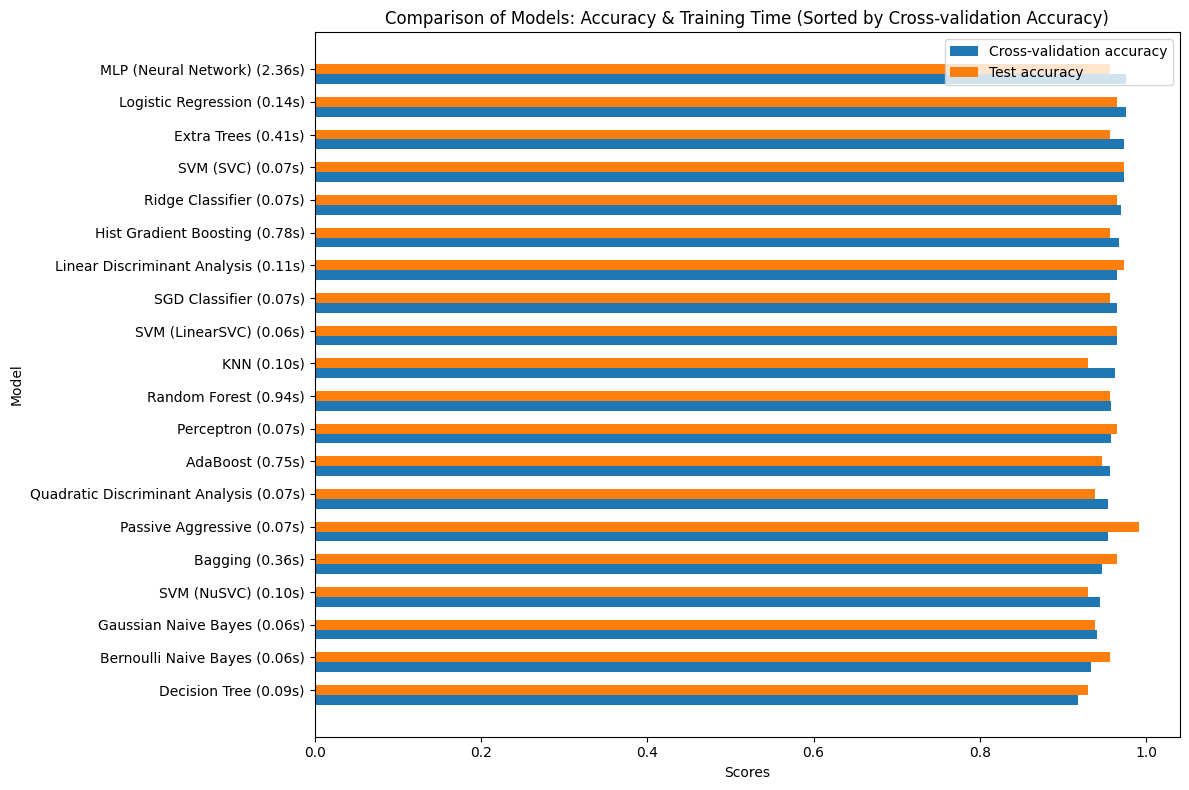

In [12]:
# Lista de modelos a evaluar
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "SGD Classifier": SGDClassifier(),
    "Perceptron": Perceptron(),
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM (SVC)": SVC(),
    "SVM (NuSVC)": NuSVC(),
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging": BaggingClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "MLP (Neural Network)": MLPClassifier()
}
# Evaluar cada modelo con validación cruzada y con conjunto de test
# Inicializar los resultados
results = {
    "model": [],
    "cross_val_results": [],
    "cross_val_score": [],
    "test_accuracy": [],
    "train_time": []
}

# Evaluar cada modelo
for name, model in models.items():
    #pipeline = make_pipeline(SMOTE(), StandardScaler(), model)  # Escalar datos si es necesario
    # Definir la pipeline con SMOTE
    pipeline = Pipeline([
    ('smote', SMOTE()),  # Se aplica solo a X_train en cada fold
    ('scaler', StandardScaler()),  
    ('model', model)  # Modelo de clasificación
    ])
    
    # Medir el tiempo de entrenamiento
    start_time = time.time()
    
    # Validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    mean_cross_val_score = np.mean(cross_val_scores)
    
    # Ajustar el modelo con el conjunto de entrenamiento completo y evaluar en test
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Guardar modelo
    # Guardar el modelo en una carpeta
    with open(f'models/{execution_name}/{name}.pkl', 'wb') as f:
        pickle.dump(pipeline, f)
    
    # Guardar los resultados
    results["model"].append(name)
    results["cross_val_results"].append(cross_val_scores)
    results["cross_val_score"].append(mean_cross_val_score)
    results["test_accuracy"].append(test_accuracy)
    results["train_time"].append(time.time() - start_time)

# Convertir resultados a numpy para facilitar el uso en la gráfica
results = {key: np.array(value) for key, value in results.items()}

# Ordenar los modelos por el mejor rendimiento en Cross-validation
sorted_indices = np.argsort(results["cross_val_score"]) # Índices ordenados de mejor a peor
sorted_results = {key: np.array(value)[sorted_indices] for key, value in results.items()}

# Crear posiciones para las barras ordenadas
x_pos_sorted = np.arange(len(models))
width = 0.3  # Ancho de las barras

# Crear la gráfica con las barras horizontales
fig, ax = plt.subplots(figsize=(12, 8))

# Barras horizontales para Cross-validation y Test accuracy
ax.barh(x_pos_sorted - width, sorted_results["cross_val_score"], width, label='Cross-validation accuracy')
ax.barh(x_pos_sorted, sorted_results["test_accuracy"], width, label='Test accuracy')

# Etiquetas y formato
ax.set_yticks(x_pos_sorted)
ax.set_yticklabels([f"{model} ({train_time:.2f}s)" for model, train_time in zip(sorted_results["model"], sorted_results["train_time"])])
ax.set_xlabel('Scores')
ax.set_ylabel('Model')
ax.set_title('Comparison of Models: Accuracy & Training Time (Sorted by Cross-validation Accuracy)')
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, VBox, Output


# Crear widgets de selección
model_selector = widgets.SelectMultiple(
    options=results["model"],
    rows=len(results["model"]),
    value=[results["model"][0]],
    description='Models',
    layout=widgets.Layout(margin='auto')

)

# Crear contenedor para la gráfica
output_plot = Output()

# Función para actualizar la gráfica
def update_plot(models_selected):
    print("hola")
    with output_plot:
        output_plot.clear_output(wait=True)
        if not models_selected:
            return
        
        indices = [np.where(results["model"] == model)[0][0] for model in models_selected]
        selected_models = [results["model"][i] for i in indices]
        selected_cross_val = results["cross_val_score"][indices]
        selected_test_acc = results["test_accuracy"][indices]
        selected_train_time = results["train_time"][indices]
        
        # Ordenar modelos seleccionados por cross_val_score
        sorted_indices = np.argsort(selected_cross_val)
        selected_models = [selected_models[i] for i in sorted_indices]
        selected_cross_val = selected_cross_val[sorted_indices]
        selected_test_acc = selected_test_acc[sorted_indices]
        selected_train_time = selected_train_time[sorted_indices]
        
        x_pos = np.arange(len(selected_models))
        width = 0.3
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(x_pos - width, selected_cross_val, width, label='Cross-validation accuracy')
        ax.barh(x_pos, selected_test_acc, width, label='Test accuracy')
        
        ax.set_yticks(x_pos)
        ax.set_yticklabels([f"{model} ({train_time:.2f}s)" for model, train_time in zip(selected_models, selected_train_time)])
        ax.set_xlabel('Scores')
        ax.set_title('Model Comparison')
        ax.legend()

        plt.tight_layout()
        plt.show()

# Disposición con HBox
layout = widgets.Layout(justify_content='center')
ui = HBox([model_selector, output_plot], layout=layout)

# Conectar el selector con la función de actualización
widgets.interactive_output(update_plot, {'models_selected': model_selector})

# Mostrar la interfaz
display(ui)

In [14]:
# Imprimir resultados ordenados por la precisión de validación cruzada
for model, cross_val_score, test_accuracy, train_time in zip(sorted_results["model"], sorted_results["cross_val_score"], sorted_results["test_accuracy"], sorted_results["train_time"]):
    print(f"{model}: Cross-validation accuracy = {cross_val_score:.4f}, Test accuracy = {test_accuracy:.4f}, Training time = {train_time:.2f} s")

Decision Tree: Cross-validation accuracy = 0.9187, Test accuracy = 0.9298, Training time = 0.09 s
Bernoulli Naive Bayes: Cross-validation accuracy = 0.9341, Test accuracy = 0.9561, Training time = 0.06 s
Gaussian Naive Bayes: Cross-validation accuracy = 0.9407, Test accuracy = 0.9386, Training time = 0.06 s
SVM (NuSVC): Cross-validation accuracy = 0.9451, Test accuracy = 0.9298, Training time = 0.10 s
Bagging: Cross-validation accuracy = 0.9473, Test accuracy = 0.9649, Training time = 0.36 s
Passive Aggressive: Cross-validation accuracy = 0.9538, Test accuracy = 0.9912, Training time = 0.07 s
Quadratic Discriminant Analysis: Cross-validation accuracy = 0.9538, Test accuracy = 0.9386, Training time = 0.07 s
AdaBoost: Cross-validation accuracy = 0.9560, Test accuracy = 0.9474, Training time = 0.75 s
Perceptron: Cross-validation accuracy = 0.9582, Test accuracy = 0.9649, Training time = 0.07 s
Random Forest: Cross-validation accuracy = 0.9582, Test accuracy = 0.9561, Training time = 0.94 

# Model Selection 

https://www.kaggle.com/code/shashwatwork/guide-to-statistical-hypothesis-tests-in-python

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

0.9


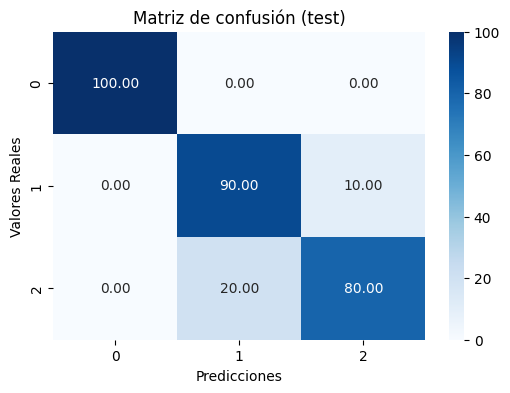

In [15]:
import pickle
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)
    
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    
    # Convertir la matriz a porcentajes (normalizando por filas)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normaliza por filas
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.title(title)
    plt.show()
    

model = load_model("models/iris/Random Forest.pkl")

X_test = pd.read_csv("dataset_iris/X_test.csv")
y_test = pd.read_csv("dataset_iris/y_test.csv").values.ravel()

# Predicciones
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

# Reporte de clasificación
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
test_accuracy = accuracy_score(y_test, y_test_pred)
print(test_accuracy)

plot_confusion_matrix(y_test, y_test_pred, np.unique(y_test), "Matriz de confusión (test)")